Image Sizes:
                                                Folder  Width  Height
0    /content/drive/MyDrive/FYP 1/thirdmolar_datase...   2438    1024
1    /content/drive/MyDrive/FYP 1/thirdmolar_datase...   2388    1024
2    /content/drive/MyDrive/FYP 1/thirdmolar_datase...   2438    1024
3    /content/drive/MyDrive/FYP 1/thirdmolar_datase...   2388    1026
4    /content/drive/MyDrive/FYP 1/thirdmolar_datase...   2347    1024
..                                                 ...    ...     ...
328  /content/drive/MyDrive/FYP 1/thirdmolar_datase...   2338    1024
329  /content/drive/MyDrive/FYP 1/thirdmolar_datase...   1572     649
330  /content/drive/MyDrive/FYP 1/thirdmolar_datase...   2438    1024
331  /content/drive/MyDrive/FYP 1/thirdmolar_datase...   2388    1024
332  /content/drive/MyDrive/FYP 1/thirdmolar_datase...   2388    1019

[333 rows x 3 columns]


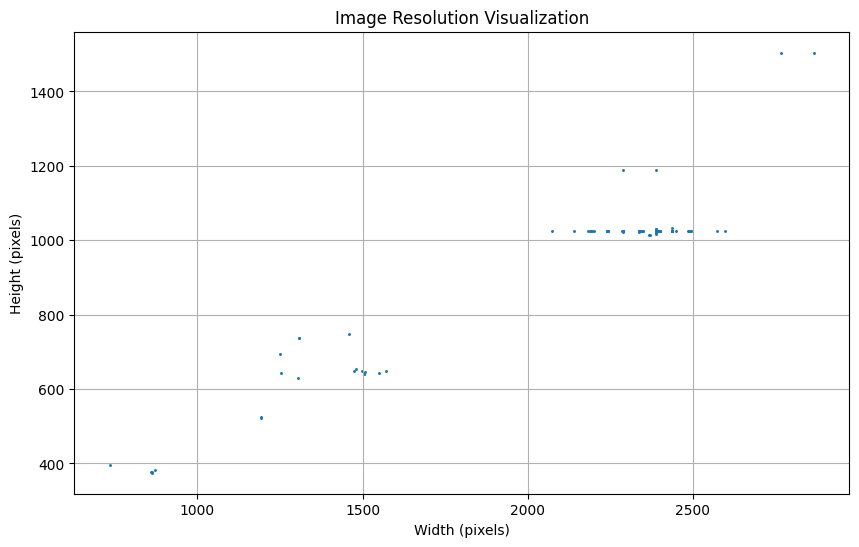

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

def visualize_resolution(image_folders):
    resolutions = {'Folder': [], 'Width': [], 'Height': []}

    for folder in image_folders:
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder, filename)
                width, height = get_image_resolution(image_path)
                resolutions['Folder'].append(folder)
                resolutions['Width'].append(width)
                resolutions['Height'].append(height)

    df = pd.DataFrame(resolutions)
    print("Image Sizes:")
    print(df)

    plt.figure(figsize=(10, 6))
    plt.scatter(resolutions['Width'], resolutions['Height'], s=5, marker='.')
    plt.title('Image Resolution Visualization')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.grid(True)
    plt.show()


# Replace these paths with the actual paths to your image folders
image_folders = [
    '/content/drive/MyDrive/FYP 1/thirdmolar_dataset/left/distoangular',
    '/content/drive/MyDrive/FYP 1/thirdmolar_dataset/left/horizontal',
    '/content/drive/MyDrive/FYP 1/thirdmolar_dataset/left/mesioangular',
    '/content/drive/MyDrive/FYP 1/thirdmolar_dataset/left/transverse',
    '/content/drive/MyDrive/FYP 1/thirdmolar_dataset/left/vertical',
]

visualize_resolution(image_folders)

Import Libraries

In [ ]:
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.notebook import tqdm
# Set random seed for reproducibility
manualSeed = 555

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  555


Definition of Hyper Parameters

In [ ]:
path = "/content/drive/MyDrive/FYP 1/thirdmolar_dataset/left"

workers = 3 # Number of workers
batch_size = 32
image_size = 64
nz = 100 # Size of z latent vector
num_epochs = 100
lr = 0.001
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers

Import Dataset

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = torchvision.datasets.ImageFolder(root=path,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),  # Assuming single channel, adjust if needed
                           ]))


# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


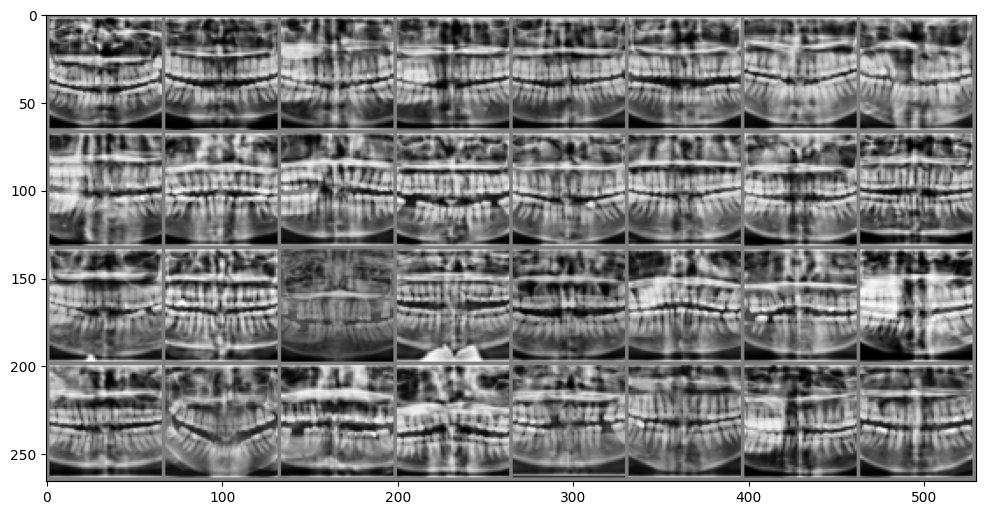

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader )
images, labels = next(dataiter)
plt.figure(figsize=(12,12))
# show images
imshow(torchvision.utils.make_grid(images))

Definition of our Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #IF WE HAVE GPU WE CAN USE It

Discriminator Class

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

            # input is `3x 64 x 64``
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

            # ``64 x 32 x 32``
        self.conv2= nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.btn2=nn.BatchNorm2d(128)
        self.relu2=nn.LeakyReLU(0.2, inplace=True)

            # ``128 x 16 x 16``
        self.conv3= nn.Conv2d(128,256, 4, 2, 1, bias=False)
        self.btn3=nn.BatchNorm2d(256)
        self.relu3=nn.LeakyReLU(0.2, inplace=True)

            # ``256 x 8 x 8``
        self.conv4= nn.Conv2d(256,512, 4, 2, 1, bias=False)
        self.btn4=nn.BatchNorm2d(512)
        self.relu4=nn.LeakyReLU(0.2, inplace=True)

            # 512 x 4 x 4``
        self.conv5= nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        self.sig=nn.Sigmoid()


    def forward(self, Input):
        output=self.conv1(Input)
        output=self.relu1(output)

        output=self.conv2(output)
        output=self.btn2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.btn3(output)
        output=self.relu3(output)

        output=self.conv4(output)
        output=self.btn4(output)
        output=self.relu4(output)

        output=self.conv5(output)
        output=self.sig(output)

        return output


Generator Class

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()


        self.convt1=nn.ConvTranspose2d( 100, 512, 4, 1, 0, bias=False)
        self.btnt1=nn.BatchNorm2d(512)
        self.relut1=nn.ReLU(True)

            # ``512*4*4``
        self.convt2=nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
        self.btnt2=nn.BatchNorm2d(256)
        self.relut2=nn.ReLU(True)

            # ``256*8*8``
        self.convt3=nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
        self.btnt3=nn.BatchNorm2d(128)
        self.relut3=nn.ReLU(True)

            # ``128*16*16``
        self.convt4=nn.ConvTranspose2d(128,64, 4, 2, 1, bias=False)
        self.btnt4=nn.BatchNorm2d(64)
        self.relut4=nn.ReLU(True)

            # 64*32*32``
        self.convt5= nn.ConvTranspose2d( 64, 1, 4, 2, 1, bias=False)
        self.tan=nn.Tanh()

     # 3*64*64``
    def forward(self, Input):
        output=self.convt1(Input)
        output=self.btnt1(output)
        output=self.relut1(output)

        output=self.convt2(output)
        output=self.btnt2(output)
        output=self.relut2(output)

        output=self.convt3(output)
        output=self.btnt3(output)
        output=self.relut3(output)

        output=self.convt4(output)
        output=self.btnt4(output)
        output=self.relut4(output)

        output=self.convt5(output)
        output=self.tan(output)

        return output

Weights Initialization

In [ ]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


Creating Networks

In [ ]:
netD = Discriminator().to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda'):
    netD = nn.DataParallel(netD)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (sig): Sigmoid()
)


In [ ]:
netG = Generator().to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda'):
    netG = nn.DataParallel(netG)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (convt1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (btnt1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut1): ReLU(inplace=True)
  (convt2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btnt2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut2): ReLU(inplace=True)
  (convt3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btnt3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut3): ReLU(inplace=True)
  (convt4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (btnt4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relut4): ReLU(inplace=True)
  (convt5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tan): Tanh

Training Networks

In [ ]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

def plot_results():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="Generator")
    plt.plot(D_losses,label="Discriminator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
# Define a function to count the number of files in a directory
def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network:
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        G_losses.append(errG.item())
        D_losses.append(errD.item())


        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# Add the following code to save generated images to folders
with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()

            # Save generated images to folders
            for class_folder in os.listdir(path):
                class_path = os.path.join(path, class_folder)
                existing_images = count_files(class_path)

                # Ensure there are exactly 200 images in each folder
                if existing_images < 200:
                    num_to_generate = min(200 - existing_images, batch_size)
                    generated_images = netG(torch.randn(num_to_generate, nz, 1, 1, device=device)).detach().cpu()
                    for idx in range(num_to_generate):
                        img_filename = f"{class_folder}_synthetic_{existing_images + idx}.png"
                        img_path = os.path.join(class_path, img_filename)
                        save_image(generated_images[idx], img_path)

[0/100][0/11]	Loss_D: 1.5055	Loss_G: 28.9538	D(x): 0.6568	D(G(z)): 0.5967 / 0.0000
[1/100][0/11]	Loss_D: 0.5053	Loss_G: 22.0684	D(x): 0.9536	D(G(z)): 0.0274 / 0.0099
[2/100][0/11]	Loss_D: 0.0896	Loss_G: 7.2352	D(x): 0.9992	D(G(z)): 0.0652 / 0.0052
[3/100][0/11]	Loss_D: 0.2667	Loss_G: 7.7547	D(x): 0.9289	D(G(z)): 0.0157 / 0.0362
[4/100][0/11]	Loss_D: 0.2732	Loss_G: 6.8190	D(x): 0.9086	D(G(z)): 0.0872 / 0.0116
[5/100][0/11]	Loss_D: 1.9495	Loss_G: 13.2199	D(x): 0.9887	D(G(z)): 0.6459 / 0.0003
[6/100][0/11]	Loss_D: 4.5766	Loss_G: 26.6349	D(x): 0.0914	D(G(z)): 0.0000 / 0.0000
[7/100][0/11]	Loss_D: 7.3420	Loss_G: 10.0204	D(x): 0.0455	D(G(z)): 0.0001 / 0.0002
[8/100][0/11]	Loss_D: 3.2426	Loss_G: 10.4213	D(x): 0.2182	D(G(z)): 0.0002 / 0.0002
[9/100][0/11]	Loss_D: 6.0727	Loss_G: 13.2694	D(x): 0.9942	D(G(z)): 0.9878 / 0.0000
[10/100][0/11]	Loss_D: 0.2905	Loss_G: 8.4217	D(x): 0.8823	D(G(z)): 0.0851 / 0.0004
[11/100][0/11]	Loss_D: 0.5553	Loss_G: 2.9862	D(x): 0.8466	D(G(z)): 0.2480 / 0.0640
[12/100

In [ ]:
plot_results()

In [ ]:
# Display generated image samples
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()